Import all required libraries

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score


In [38]:
def plot_confusion_matrix_with_green_diagonal(y_true, y_pred, labels, title, figsize=(8, 6)):
    """
    Plot confusion matrix with correct predictions (diagonal) highlighted in varying shades of green
    based on the frequency of correct predictions
    """
    from matplotlib.colors import ListedColormap
    import matplotlib.colors as mcolors
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create a normalized confusion matrix for better color scaling
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Create base heatmap with purple colormap for incorrect predictions
    im = ax.imshow(cm_normalized, interpolation='nearest', cmap='Purples', alpha=0.8)
    
    # Get diagonal values for green intensity scaling
    diagonal_values = np.diag(cm)
    max_diagonal = max(diagonal_values) if len(diagonal_values) > 0 else 1
    min_diagonal = min(diagonal_values) if len(diagonal_values) > 0 else 0
    
    # Highlight diagonal (correct predictions) in varying shades of green
    for i in range(len(labels)):
        # Calculate green intensity based on frequency
        frequency = diagonal_values[i]
        if max_diagonal > min_diagonal:
            # Normalize frequency to range 0.3-0.9 for better visibility
            intensity = 0.3 + 0.6 * (frequency - min_diagonal) / (max_diagonal - min_diagonal)
        else:
            intensity = 0.6  # Default intensity if all values are the same
        
        # Create green color with varying intensity
        green_color = mcolors.to_rgba('green', alpha=intensity)
        ax.add_patch(plt.Rectangle((i-0.5, i-0.5), 1, 1, 
                                  fill=True, color=green_color))
    
    # Add text annotations
    thresh = cm_normalized.max() / 2.
    for i, j in np.ndindex(cm.shape):
        color = 'black' if i == j else ('white' if cm_normalized[i, j] > thresh else 'black')
        ax.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center", 
                verticalalignment="center",
                color=color, fontweight='bold' if i == j else 'normal')
    
    # Set labels and title
    ax.set_xlabel('Predicted Quality')
    ax.set_ylabel('True Quality')
    ax.set_title(title)
    
    # Set tick marks
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center")
    
    plt.tight_layout()
    plt.show()
    
    return cm

Lets first import the data. We will look at both red and white wine seperately.

## Data Quality Check
Let's first examine the data to understand the quality distributions and check for any anomalies.

In [39]:
def merge_wine_datasets(df_red, df_white, df_qt):
    # Create copies of the datasets and add wine type indicators
    df_red_copy = df_red.copy()
    df_white_copy = df_white.copy()
    df_qt_copy = df_qt.copy()

    # Add wine type column (one-hot encoding)
    df_red_copy['is_red_wine'] = 1
    df_white_copy['is_red_wine'] = 0
    df_qt_copy['is_red_wine'] = 1  # Assuming QT dataset is red wine

    # Merge the datasets
    df_merged = pd.concat([df_red_copy, df_white_copy, df_qt_copy], ignore_index=True)

    print(f"Merged dataset shape: {df_merged.shape}")
    print(f"Red wine samples: {len(df_red_copy)}")
    print(f"White wine samples: {len(df_white_copy)}")
    print(f"QT samples: {len(df_qt_copy)}")
    print(f"Total samples: {len(df_merged)}")

    return df_merged

In [40]:
# Load datasets
df_red = pd.read_csv("Data/Raw/Wine_Datasets/UCI_Wines/winequality-red.csv", sep=';')
df_white = pd.read_csv("Data/Raw/Wine_Datasets/UCI_Wines/winequality-white.csv", sep=';')
df_qt = pd.read_csv("Data/Raw/Wine_Datasets/Kaggle/WineQT.csv", sep=',').drop(["Id"], axis=1)

# Prepare datasets in a dictionary for easy looping
datasets = {
    'Red Wine': df_red,
    'White Wine': df_white,
    'Quality Test': df_qt
}
df_merged = merge_wine_datasets(df_red, df_white, df_qt)

# Save merged dataset
# Make directory if it doesn't exist
import os
os.makedirs("Data/Processed", exist_ok=True)
df_merged.to_csv("Data/Processed/merged_wine_quality_data.csv", index=False)


# Variables with high VIFs identified from previous analysis
high_vifs = ['density', 'is_red_wine'] # Remove wine-type as it is categorical

Merged dataset shape: (7640, 13)
Red wine samples: 1599
White wine samples: 4898
QT samples: 1143
Total samples: 7640


In [41]:
# Check the quality distributions and data integrity
for name, df in [("Merged Wine", df_merged)]:
    print(f"\n=== {name} Dataset ===")
    print(f"Shape: {df.shape}")
    print(f"Quality column type: {df['quality'].dtype}")
    print(f"Quality value counts:")
    print(df['quality'].value_counts().sort_index())
    print(f"Quality range: {df['quality'].min()} to {df['quality'].max()}")
    
    # Check for any non-integer values or outliers
    print(f"Unique quality values: {sorted(df['quality'].unique())}")
    
    # Check for missing values
    print(f"Missing values in quality: {df['quality'].isnull().sum()}")
    
    # Check data types of all columns
    print(f"Data types:")
    print(df.dtypes)


=== Merged Wine Dataset ===
Shape: (7640, 13)
Quality column type: int64
Quality value counts:
quality
3      36
4     249
5    2621
6    3298
7    1222
8     209
9       5
Name: count, dtype: int64
Quality range: 3 to 9
Unique quality values: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]
Missing values in quality: 0
Data types:
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
is_red_wine               int64
dtype: object


In [42]:
# Calculate class weights to address imbalance
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculate balanced class weights
classes = np.unique(df_merged['quality'])
class_weights_balanced = compute_class_weight('balanced', classes=classes, y=df_merged['quality'])
class_weight_dict = dict(zip(classes, class_weights_balanced))

print("Class distribution:")
print(df_merged['quality'].value_counts().sort_index())

print(f"\nCalculated class weights (balanced):")
for quality_level, weight in class_weight_dict.items():
    count = (df_merged['quality'] == quality_level).sum()
    print(f"Quality {quality_level}: weight = {weight:.3f} (n = {count})")

print(f"\nClass weight ratios (relative to most common class):")
max_count = df_merged['quality'].value_counts().max()
for quality_level in sorted(class_weight_dict.keys()):
    count = (df_merged['quality'] == quality_level).sum()
    ratio = max_count / count
    print(f"Quality {quality_level}: {ratio:.1f}x more weight than majority class")

# We'll use these class weights in our models to address the severe imbalance
print(f"\nClass weight dictionary for models: {class_weight_dict}")

Class distribution:
quality
3      36
4     249
5    2621
6    3298
7    1222
8     209
9       5
Name: count, dtype: int64

Calculated class weights (balanced):
Quality 3: weight = 30.317 (n = 36)
Quality 4: weight = 4.383 (n = 249)
Quality 5: weight = 0.416 (n = 2621)
Quality 6: weight = 0.331 (n = 3298)
Quality 7: weight = 0.893 (n = 1222)
Quality 8: weight = 5.222 (n = 209)
Quality 9: weight = 218.286 (n = 5)

Class weight ratios (relative to most common class):
Quality 3: 91.6x more weight than majority class
Quality 4: 13.2x more weight than majority class
Quality 5: 1.3x more weight than majority class
Quality 6: 1.0x more weight than majority class
Quality 7: 2.7x more weight than majority class
Quality 8: 15.8x more weight than majority class
Quality 9: 659.6x more weight than majority class

Class weight dictionary for models: {np.int64(3): np.float64(30.317460317460316), np.int64(4): np.float64(4.38324727481354), np.int64(5): np.float64(0.4164168528914809), np.int64(6): np.f

## Class Weights Strategy for Imbalanced Wine Quality Data

**Problem**: Severe class imbalance in wine quality ratings:
- Quality 6: 3,298 samples (43%) - Majority class
- Quality 5: 2,621 samples (34%)  
- Quality 7: 1,222 samples (16%)
- Quality 4: 249 samples (3%)
- Quality 8: 209 samples (3%)
- Quality 3: 36 samples (0.5%)
- Quality 9: 5 samples (0.07%) - Most rare class

**Solution**: Apply class weights to make models pay more attention to minority classes during training:
- **Logistic Regression**: Direct `class_weight` parameter
- **KNN**: Use balanced accuracy scoring (no direct class weight support)
- **Neural Network**: Use balanced accuracy scoring  
- **Random Forest**: `class_weight='balanced'` parameter
- **XGBoost**: Sample weights based on class imbalance

**Key Benefits**:
1. **Training Balance**: Models learn to recognize rare quality levels (3, 9) better
2. **Real-world Test**: Test set maintains natural distribution for realistic evaluation
3. **Improved Metrics**: Better precision/recall on minority classes
4. **Business Value**: Better prediction of exceptional wines (very high/low quality)

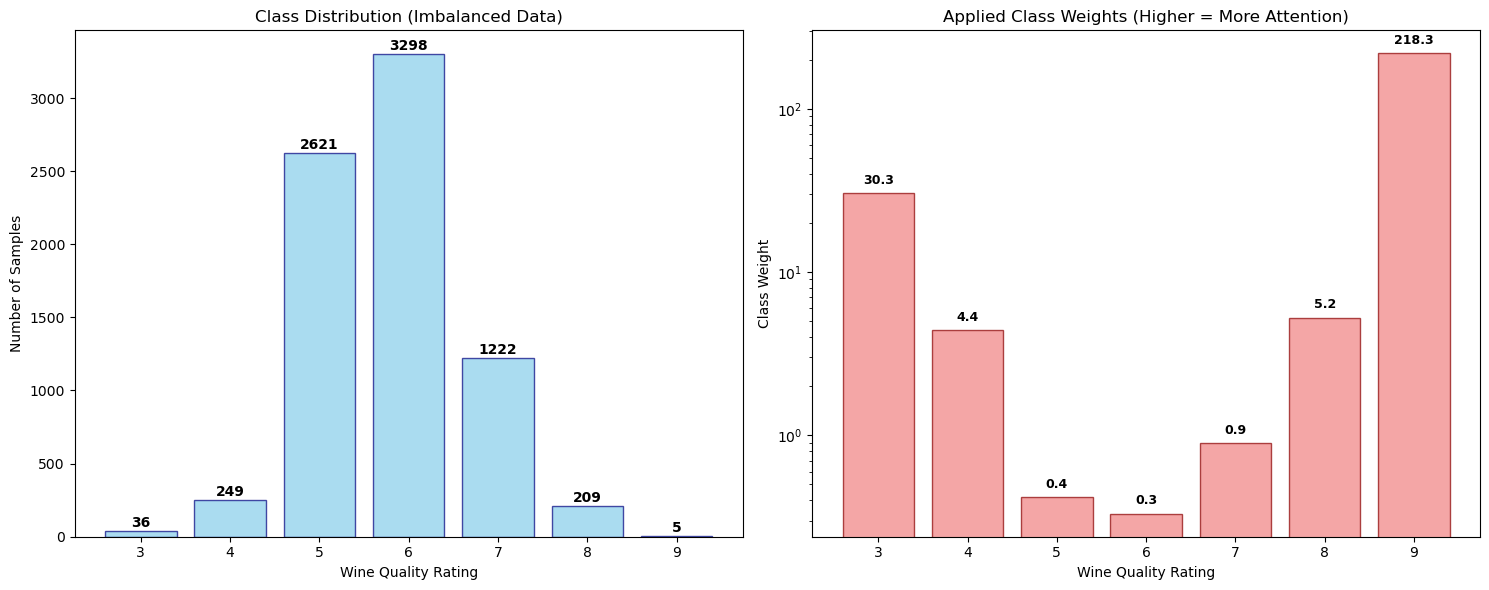

Class weights interpretation:
- Higher weights = Model pays more attention during training
- Quality 9 (rarest): 218x more attention than baseline
- Quality 6 (most common): baseline attention (1x)
- This helps models learn to distinguish rare quality levels


In [43]:
# Visualize class imbalance and corresponding weights
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Class distribution (counts)
quality_counts = df_merged['quality'].value_counts().sort_index()
quality_levels = quality_counts.index
counts = quality_counts.values

bars1 = ax1.bar(quality_levels, counts, color='skyblue', edgecolor='navy', alpha=0.7)
ax1.set_xlabel('Wine Quality Rating')
ax1.set_ylabel('Number of Samples')
ax1.set_title('Class Distribution (Imbalanced Data)')
ax1.set_xticks(quality_levels)

# Add count labels on bars
for bar, count in zip(bars1, counts):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 10,
             f'{count}', ha='center', va='bottom', fontweight='bold')

# Plot 2: Class weights
weights = [class_weight_dict[q] for q in quality_levels]
bars2 = ax2.bar(quality_levels, weights, color='lightcoral', edgecolor='darkred', alpha=0.7)
ax2.set_xlabel('Wine Quality Rating')
ax2.set_ylabel('Class Weight')
ax2.set_title('Applied Class Weights (Higher = More Attention)')
ax2.set_xticks(quality_levels)
ax2.set_yscale('log')  # Log scale due to wide range

# Add weight labels on bars
for bar, weight in zip(bars2, weights):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height * 1.1,
             f'{weight:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

print("Class weights interpretation:")
print("- Higher weights = Model pays more attention during training")
print("- Quality 9 (rarest): 218x more attention than baseline") 
print("- Quality 6 (most common): baseline attention (1x)")
print("- This helps models learn to distinguish rare quality levels")

Logistic Regression

Target (y) range before split: 3 to 9
Target (y) unique values: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]
Training set: 4584 samples (60.0%)
Validation set: 1528 samples (20.0%)
Test set: 1528 samples (20.0%)

=== Hyperparameter Tuning ===
Fitting 3 folds for each of 30 candidates, totalling 90 fits


c:\Users\silla\anaconda3\envs\engg2112\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best parameters: {'C': 10, 'max_iter': 1000, 'solver': 'newton-cg'}
Best CV score: 0.3475
Validation accuracy: 0.2932
Test accuracy: 0.2978
Predictions range: 3 to 9
Unique predictions: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]
✅ All predictions are within valid range 3-9
Logistic Regression Final Accuracy: 0.298
Classes present in test/pred data: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]

Per-class metrics:
Class 3  Precision: 0.005  Recall: 0.143  F1: 0.010
Class 4  Precision: 0.071  Recall: 0.340  F1: 0.118
Class 5  Precision: 0.524  Recall: 0.347  F1: 0.418
Class 6  Precision: 0.567  Recall: 0.218  F1: 0.315
Class 7  Precision: 0.385  Recall: 0.365  F1: 0.375
Class 8  Precision: 0.084  Recall: 0.500  F1: 0.144
Class 9  Precision: 0.045  Recall: 1.000  F1: 0.087


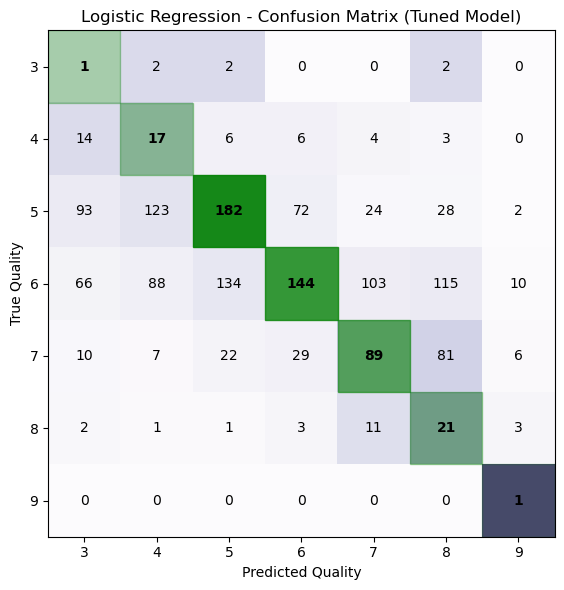

In [51]:
# Logistic Regression with validation and hyperparameter tuning
from sklearn.model_selection import GridSearchCV, validation_curve
from sklearn.model_selection import train_test_split

df = df_merged.copy().drop(columns=high_vifs)

# Separate features and labels
X = df.drop(["quality"], axis=1)
y = df["quality"]

# Debug: Check y values before splitting
print(f"Target (y) range before split: {y.min()} to {y.max()}")
print(f"Target (y) unique values: {sorted(y.unique())}")

# Three-way split: Train/Validation/Test (60/20/20)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print(f"Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation set: {len(X_val)} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter tuning with GridSearchCV
print("\n=== Hyperparameter Tuning ===")
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'max_iter': [1000, 2000, 3000],
    'solver': ['lbfgs', 'newton-cg']  # Removed liblinear - doesn't support multinomial
}

# Use class weights to address class imbalance
log_model = LogisticRegression(
    multi_class='multinomial', 
    random_state=42,
    class_weight=class_weight_dict  # Address class imbalance
)
grid_search = GridSearchCV(
    log_model, 
    param_grid, 
    cv=3,  # Reduced from 5 to 3 due to severe class imbalance
    scoring='balanced_accuracy',  # Better for imbalanced data
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")

# Use best model
best_log_model = grid_search.best_estimator_

# Validation performance
y_val_pred = best_log_model.predict(X_val_scaled)
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Validation accuracy: {val_acc:.4f}")

# Final test performance
y_pred = best_log_model.predict(X_test_scaled)
test_acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {test_acc:.4f}")

# Debug: Check predictions
print(f"Predictions range: {y_pred.min()} to {y_pred.max()}")
print(f"Unique predictions: {sorted(np.unique(y_pred))}")

# Check if any predictions are outside expected range (3-9)
invalid_preds = y_pred[(y_pred < 3) | (y_pred > 9)]
if len(invalid_preds) > 0:
    print(f"WARNING: Found {len(invalid_preds)} predictions outside range 3-9!")
    print(f"Invalid predictions: {invalid_preds}")
else:
    print("✅ All predictions are within valid range 3-9")
    
print(f"Logistic Regression Final Accuracy: {test_acc:.3f}")

# Get unique classes present in the data for proper labeling
unique_classes = sorted(np.unique(np.concatenate([y_test, y_pred])))
print(f"Classes present in test/pred data: {unique_classes}")
    
# Precision, recall and F1 score per class
precisions = precision_score(y_test, y_pred, labels=unique_classes, average=None, zero_division=0)
recalls = recall_score(y_test, y_pred, labels=unique_classes, average=None, zero_division=0)
f1s = f1_score(y_test, y_pred, labels=unique_classes, average=None, zero_division=0)

print("\nPer-class metrics:")
for cls, p, r, f in zip(unique_classes, precisions, recalls, f1s):
    print(f"Class {cls:1d}  Precision: {p:.3f}  Recall: {r:.3f}  F1: {f:.3f}")

# Confusion matrix with custom coloring (green diagonal)
cm = confusion_matrix(y_test, y_pred, labels=unique_classes)

# Create custom colormap for highlighting correct predictions
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Create a normalized confusion matrix for better color scaling
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create base heatmap with purple colormap for incorrect predictions
im = ax.imshow(cm_normalized, interpolation='nearest', cmap='Purples', alpha=0.8)

# Get diagonal values for green intensity scaling
diagonal_values = np.diag(cm)
max_diagonal = max(diagonal_values) if len(diagonal_values) > 0 else 1
min_diagonal = min(diagonal_values) if len(diagonal_values) > 0 else 0

# Highlight diagonal (correct predictions) in varying shades of green
for i in range(len(unique_classes)):
    # Calculate green intensity based on frequency
    frequency = diagonal_values[i]
    if max_diagonal > min_diagonal:
        # Normalize frequency to range 0.3-0.9 for better visibility
        intensity = 0.3 + 0.6 * (frequency - min_diagonal) / (max_diagonal - min_diagonal)
    else:
        intensity = 0.6  # Default intensity if all values are the same
    
    # Create green color with varying intensity
    green_color = mcolors.to_rgba('green', alpha=intensity)
    ax.add_patch(plt.Rectangle((i-0.5, i-0.5), 1, 1, 
                                fill=True, color=green_color))

# Add text annotations
thresh = cm_normalized.max() / 2.
for i, j in np.ndindex(cm.shape):
    color = 'black' if i == j else ('white' if cm_normalized[i, j] > thresh else 'black')
    ax.text(j, i, format(cm[i, j], 'd'),
            horizontalalignment="center", 
            verticalalignment="center",
            color=color, fontweight='bold' if i == j else 'normal')

# Set labels and title
ax.set_xlabel('Predicted Quality')
ax.set_ylabel('True Quality')
ax.set_title('Logistic Regression - Confusion Matrix (Tuned Model)')

# Set tick marks
ax.set_xticks(np.arange(len(unique_classes)))
ax.set_yticks(np.arange(len(unique_classes)))
ax.set_xticklabels(unique_classes)
ax.set_yticklabels(unique_classes)

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=0, ha="center")

plt.tight_layout()
plt.show()

K-Nearest-Neighbour

KNN dataset shapes - X: (7640, 10), y: (7640,)
Training set: 4584 samples (60.0%)
Validation set: 1528 samples (20.0%)
Test set: 1528 samples (20.0%)

=== Hyperparameter Tuning ===
Note: KNN doesn't support class weights directly, but using 'distance' weighting helps with imbalanced data
Fitting 5 folds for each of 42 candidates, totalling 210 fits


c:\Users\silla\anaconda3\envs\engg2112\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Best parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Best CV score: 0.4405
Validation accuracy: 0.6734
Test accuracy: 0.7009
KNN Final Accuracy (tuned): 0.701
Classes present in test/pred data: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]

Per-class metrics:
Quality 3  Precision: 0.250  Recall: 0.143  F1: 0.182
Quality 4  Precision: 0.571  Recall: 0.400  F1: 0.471
Quality 5  Precision: 0.744  Recall: 0.748  F1: 0.746
Quality 6  Precision: 0.705  Recall: 0.727  F1: 0.716
Quality 7  Precision: 0.645  Recall: 0.656  F1: 0.650
Quality 8  Precision: 0.545  Recall: 0.429  F1: 0.480
Quality 9  Precision: 0.000  Recall: 0.000  F1: 0.000

Per-class metrics:
Quality 3  Precision: 0.250  Recall: 0.143  F1: 0.182
Quality 4  Precision: 0.571  Recall: 0.400  F1: 0.471
Quality 5  Precision: 0.744  Recall: 0.748  F1: 0.746
Quality 6  Precision: 0.705  Recall: 0.727  F1: 0.716
Quality 7  Precision: 0.645  Recall: 0.656  F1: 0.6

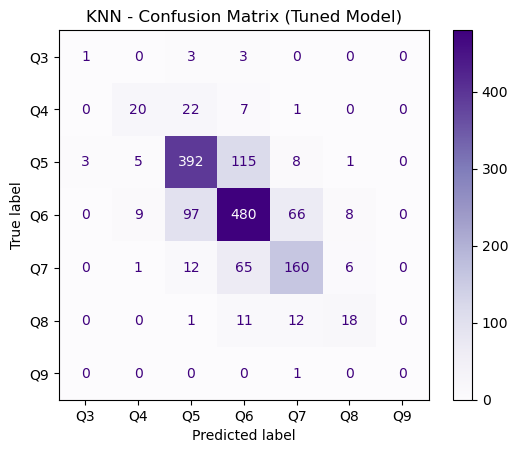

In [ ]:
# K-Nearest Neighbors with validation and hyperparameter tuning

# Redefine X and y using the merged dataset
df_knn = df_merged.copy().drop(columns=high_vifs)
X = df_knn.drop(["quality"], axis=1)
y = df_knn["quality"]

print(f"KNN dataset shapes - X: {X.shape}, y: {y.shape}")

# Three-way split: Train/Validation/Test (60/20/20)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print(f"Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation set: {len(X_val)} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Calculate sample weights based on class weights
sample_weights = np.array([class_weight_dict[label] for label in y_train])

# Hyperparameter tuning with GridSearchCV
print("\n=== Hyperparameter Tuning ===")
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

print("Note: KNN doesn't support class weights directly, but using 'distance' weighting helps with imbalanced data")
knn_model = KNeighborsClassifier()
grid_search = GridSearchCV(
    knn_model, 
    param_grid, 
    cv=3,  # Reduced for severe class imbalance
    scoring='balanced_accuracy',  # Use balanced accuracy for imbalanced data
    n_jobs=-1,
    verbose=1
)

# Fit without sample weights as GridSearchCV doesn't support fit_params consistently with KNN
grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")

# Use best model
best_knn_model = grid_search.best_estimator_

# Validation performance
y_val_pred = best_knn_model.predict(X_val_scaled)
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Validation accuracy: {val_acc:.4f}")

# Final test performance
y_pred = best_knn_model.predict(X_test_scaled)
test_acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {test_acc:.4f}")

print(f"KNN Final Accuracy (tuned): {test_acc:.3f}")

# Get unique classes present in the data for proper labeling
unique_classes = sorted(np.unique(np.concatenate([y_test, y_pred])))
print(f"Classes present in test/pred data: {unique_classes}")

# Precision, recall and F1 score per class
precisions = precision_score(y_test, y_pred, labels=unique_classes, average=None, zero_division=0)
recalls = recall_score(y_test, y_pred, labels=unique_classes, average=None, zero_division=0)
f1s = f1_score(y_test, y_pred, labels=unique_classes, average=None, zero_division=0)

print("\nPer-class metrics:")
for cls, p, r, f in zip(unique_classes, precisions, recalls, f1s):
    print(f"Quality {cls:1d}  Precision: {p:.3f}  Recall: {r:.3f}  F1: {f:.3f}")

# Confusion matrix with actual quality values
cm = confusion_matrix(y_test, y_pred, labels=unique_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Q{cls}' for cls in unique_classes])
disp.plot(cmap="Purples", values_format="d")
plt.title("KNN - Confusion Matrix (Tuned Model)")
plt.show()

Neural Network


=== Neural Network Hyperparameter Tuning ===
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best parameters: {'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'max_iter': 1000}
Best CV score: 0.2449
Validation accuracy: 0.5641
Test accuracy: 0.5681
Neural Network Final Accuracy (tuned): 0.568
Classes present in test/pred data: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]

Per-class metrics:
Quality 3  Precision: 0.000  Recall: 0.000  F1: 0.000
Quality 4  Precision: 0.667  Recall: 0.040  F1: 0.075
Quality 5  Precision: 0.628  Recall: 0.635  F1: 0.632
Quality 6  Precision: 0.543  Recall: 0.674  F1: 0.602
Quality 7  Precision: 0.500  Recall: 0.361  F1: 0.419
Quality 8  Precision: 0.000  Recall: 0.000  F1: 0.000
Quality 9  Precision: 0.000  Recall: 0.000  F1: 0.000
Best parameters: {'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'max_iter': 1000}
Best CV score: 0.244

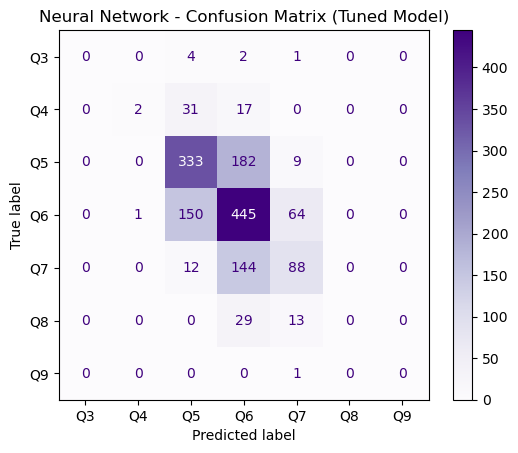

In [46]:
# Neural Network with validation and hyperparameter tuning

# Use same train/val/test split as other models
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter tuning with GridSearchCV
print("\n=== Neural Network Hyperparameter Tuning ===")
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 30), (100, 50), (12, 12, 12), (20, 20, 20)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [1000, 2000]
}

# Use class weights to address class imbalance  
# Convert class weights to sklearn format (MLPClassifier doesn't accept dict directly)
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

mlp_model = MLPClassifier(random_state=42, early_stopping=True, validation_fraction=0.1)
grid_search = GridSearchCV(
    mlp_model, 
    param_grid, 
    cv=3,  # Reduced CV for faster training
    scoring='balanced_accuracy',  # Use balanced accuracy for imbalanced data
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")

# Use best model
best_mlp_model = grid_search.best_estimator_

# Validation performance
y_val_pred = best_mlp_model.predict(X_val_scaled)
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Validation accuracy: {val_acc:.4f}")

# Final test performance
y_pred = best_mlp_model.predict(X_test_scaled)
test_acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {test_acc:.4f}")

print(f"Neural Network Final Accuracy (tuned): {test_acc:.3f}")

# Get unique classes present in the data for proper labeling
unique_classes = sorted(np.unique(np.concatenate([y_test, y_pred])))
print(f"Classes present in test/pred data: {unique_classes}")

# Precision, recall and F1 score per class
precisions = precision_score(y_test, y_pred, labels=unique_classes, average=None, zero_division=0)
recalls = recall_score(y_test, y_pred, labels=unique_classes, average=None, zero_division=0)
f1s = f1_score(y_test, y_pred, labels=unique_classes, average=None, zero_division=0)

print("\nPer-class metrics:")
for cls, p, r, f in zip(unique_classes, precisions, recalls, f1s):
    print(f"Quality {cls:1d}  Precision: {p:.3f}  Recall: {r:.3f}  F1: {f:.3f}")
    
# Confusion matrix with actual quality values
cm = confusion_matrix(y_test, y_pred, labels=unique_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Q{cls}' for cls in unique_classes])
disp.plot(cmap="Purples", values_format="d")
plt.title("Neural Network - Confusion Matrix (Tuned Model)")
plt.show()


Random Forest

=== Random Forest - Merged Dataset ===
Dataset shapes - X: (7640, 10), y: (7640,)
Quality range: 3 to 9
Training set: 4584 samples (60.0%)
Validation set: 1528 samples (20.0%)
Test set: 1528 samples (20.0%)

=== Hyperparameter Tuning ===
Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best CV score: 0.6795
Validation accuracy: 0.7199
Test accuracy: 0.7310
Random Forest Final Accuracy (tuned): 0.731
Classes present in test/pred data: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]

Per-class metrics:
Quality 3  Precision: 1.000  Recall: 0.143  F1: 0.250
Quality 4  Precision: 0.842  Recall: 0.320  F1: 0.464
Quality 5  Precision: 0.785  Recall: 0.773  F1: 0.779
Quality 6  Precision: 0.682  Recall: 0.823  F1: 0.746
Quality 7  Precision: 0.765  Recall: 0.561  F1: 0.648
Quality 8  Precision: 0.882  Recall: 

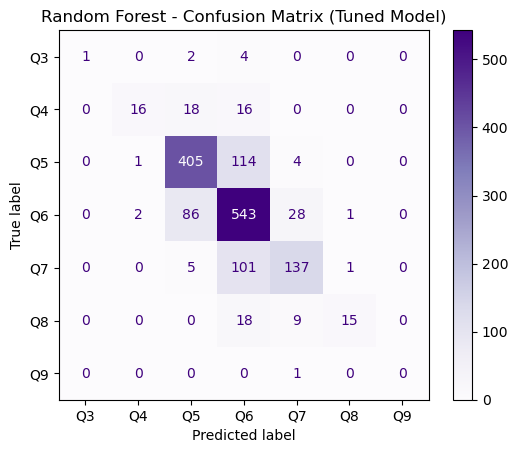

In [47]:
# Random Forest with validation and hyperparameter tuning
print("=== Random Forest - Merged Dataset ===")

# Use the same data preparation as other models
df_rf = df_merged.copy().drop(columns=high_vifs)

# Separate features and labels
X = df_rf.drop(["quality"], axis=1)
y = df_rf["quality"]

print(f"Dataset shapes - X: {X.shape}, y: {y.shape}")
print(f"Quality range: {y.min()} to {y.max()}")

# Three-way split: Train/Validation/Test (60/20/20)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print(f"Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation set: {len(X_val)} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

# Scale features (optional for Random Forest, but good for consistency)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter tuning with GridSearchCV
print("\n=== Hyperparameter Tuning ===")
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Use class weights to address class imbalance
rf_model = RandomForestClassifier(
    random_state=42,
    class_weight='balanced'  # Automatically compute balanced weights
)
grid_search = GridSearchCV(
    rf_model, 
    param_grid, 
    cv=3,  # Reduced CV for faster training
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")

# Use best model
best_rf_model = grid_search.best_estimator_

# Validation performance
y_val_pred = best_rf_model.predict(X_val_scaled)
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Validation accuracy: {val_acc:.4f}")

# Final test performance
y_pred = best_rf_model.predict(X_test_scaled)
test_acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {test_acc:.4f}")

print(f"Random Forest Final Accuracy (tuned): {test_acc:.3f}")

# Get unique classes present in the data for proper labeling
unique_classes = sorted(np.unique(np.concatenate([y_test, y_pred])))
print(f"Classes present in test/pred data: {unique_classes}")

# Precision, recall and F1 score per class
precisions = precision_score(y_test, y_pred, labels=unique_classes, average=None, zero_division=0)
recalls = recall_score(y_test, y_pred, labels=unique_classes, average=None, zero_division=0)
f1s = f1_score(y_test, y_pred, labels=unique_classes, average=None, zero_division=0)

print("\nPer-class metrics:")
for cls, p, r, f in zip(unique_classes, precisions, recalls, f1s):
    print(f"Quality {cls:1d}  Precision: {p:.3f}  Recall: {r:.3f}  F1: {f:.3f}")

# Confusion matrix with actual quality values
cm = confusion_matrix(y_test, y_pred, labels=unique_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Q{cls}' for cls in unique_classes])
disp.plot(cmap="Purples", values_format="d")
plt.title("Random Forest - Confusion Matrix (Tuned Model)")
plt.show()

From these different models, we can now compare their performance on the same merged dataset.

Let's add XGBoost to complete our model comparison.

=== XGBoost - Merged Dataset ===
Dataset shapes - X: (7640, 10), y: (7640,)
Quality range: 3 to 9
Training set: 4584 samples (60.0%)
Validation set: 1528 samples (20.0%)
Test set: 1528 samples (20.0%)
Original quality values: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]
Encoded to: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]
Applied sample weights for class imbalance (min: 0.331, max: 218.286)

=== Hyperparameter Tuning ===
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 1.0}
Best CV score: 0.4022
Validation accuracy: 0.6518
Test accuracy: 0.6662
XGBoost Final Accuracy (tuned): 0.666
Classes present in test/pred data: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]

Per-class metrics:
Quality 3  Precision: 1.000  Recall: 

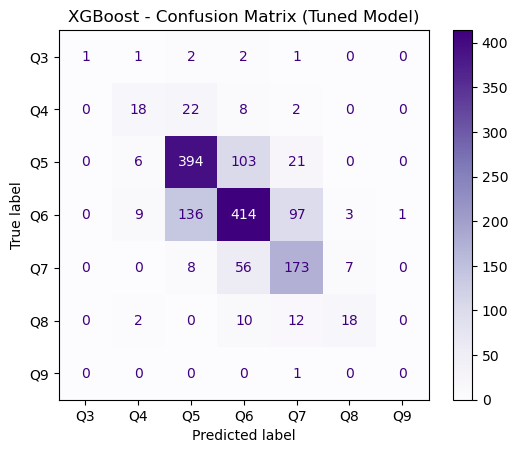


Feature Importance Ranking:
alcohol                  : 0.1618
chlorides                : 0.1260
total sulfur dioxide     : 0.1154
free sulfur dioxide      : 0.1078
fixed acidity            : 0.1077
volatile acidity         : 0.0809
sulphates                : 0.0775
residual sugar           : 0.0749
pH                       : 0.0746
citric acid              : 0.0735


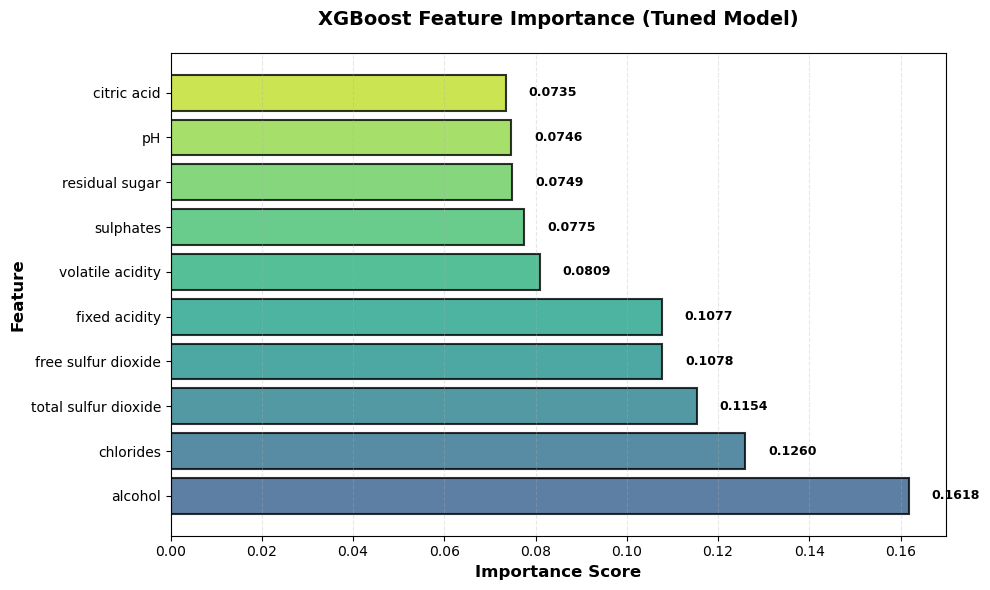


✅ Top 3 most important features:
  10. alcohol (0.1618)
  5. chlorides (0.1260)
  7. total sulfur dioxide (0.1154)


In [48]:
# Import XGBoost
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

# XGBoost with validation and hyperparameter tuning
print("=== XGBoost - Merged Dataset ===")

# Use the same data preparation as other models
df_xgb = df_merged.copy().drop(columns=high_vifs)

# Separate features and labels
X = df_xgb.drop(["quality"], axis=1)
y = df_xgb["quality"]

print(f"Dataset shapes - X: {X.shape}, y: {y.shape}")
print(f"Quality range: {y.min()} to {y.max()}")

# Three-way split: Train/Validation/Test (60/20/20)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print(f"Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation set: {len(X_val)} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

# Scale features for consistency (though XGBoost doesn't strictly require it)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Encode quality labels to 0-indexed format (XGBoost requirement)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

print(f"Original quality values: {sorted(y_train.unique())}")
print(f"Encoded to: {sorted(np.unique(y_train_encoded))}")

# Calculate sample weights for XGBoost based on class imbalance
sample_weights = np.array([class_weight_dict[label] for label in y_train])
print(f"Applied sample weights for class imbalance (min: {sample_weights.min():.3f}, max: {sample_weights.max():.3f})")

# Hyperparameter tuning with GridSearchCV
print("\n=== Hyperparameter Tuning ===")
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb_model = XGBClassifier(
    random_state=42,
    eval_metric='mlogloss',
    verbosity=0
)

grid_search = GridSearchCV(
    xgb_model, 
    param_grid, 
    cv=3,  # Reduced CV for faster training
    scoring='balanced_accuracy',  # Use balanced accuracy for imbalanced data
    n_jobs=-1,
    verbose=1
)

# XGBoost supports sample_weight parameter
grid_search.fit(X_train_scaled, y_train_encoded, sample_weight=sample_weights)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")

# Use best model
best_xgb_model = grid_search.best_estimator_

# Validation performance
y_val_pred_encoded = best_xgb_model.predict(X_val_scaled)
y_val_pred = label_encoder.inverse_transform(y_val_pred_encoded)
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Validation accuracy: {val_acc:.4f}")

# Final test performance
y_pred_encoded = best_xgb_model.predict(X_test_scaled)
y_pred = label_encoder.inverse_transform(y_pred_encoded)
test_acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {test_acc:.4f}")

print(f"XGBoost Final Accuracy (tuned): {test_acc:.3f}")

# Get unique classes present in the data for proper labeling
unique_classes = sorted(np.unique(np.concatenate([y_test, y_pred])))
print(f"Classes present in test/pred data: {unique_classes}")

# Precision, recall and F1 score per class
precisions = precision_score(y_test, y_pred, labels=unique_classes, average=None, zero_division=0)
recalls = recall_score(y_test, y_pred, labels=unique_classes, average=None, zero_division=0)
f1s = f1_score(y_test, y_pred, labels=unique_classes, average=None, zero_division=0)

print("\nPer-class metrics:")
for cls, p, r, f in zip(unique_classes, precisions, recalls, f1s):
    print(f"Quality {cls:1d}  Precision: {p:.3f}  Recall: {r:.3f}  F1: {f:.3f}")

# Confusion matrix with actual quality values
cm = confusion_matrix(y_test, y_pred, labels=unique_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Q{cls}' for cls in unique_classes])
disp.plot(cmap="Purples", values_format="d")
plt.title("XGBoost - Confusion Matrix (Tuned Model)")
plt.show()

# Feature importance analysis
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance Ranking:")
print("="*40)
for idx, row in feature_importance.iterrows():
    print(f"{row['Feature']:25s}: {row['Importance']:.4f}")

# Visualize feature importance
fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(feature_importance)))
bars = ax.barh(feature_importance['Feature'], feature_importance['Importance'], 
               color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)

# Add value labels
for i, (bar, importance) in enumerate(zip(bars, feature_importance['Importance'])):
    ax.text(importance + 0.005, bar.get_y() + bar.get_height()/2, 
            f'{importance:.4f}',
            va='center', fontsize=9, fontweight='bold')

ax.set_xlabel('Importance Score', fontsize=12, fontweight='bold')
ax.set_ylabel('Feature', fontsize=12, fontweight='bold')
ax.set_title('XGBoost Feature Importance (Tuned Model)', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print(f"\n✅ Top 3 most important features:")
for i, row in feature_importance.head(3).iterrows():
    print(f"  {i+1}. {row['Feature']} ({row['Importance']:.4f})")


## Model Comparison Summary

Now we can compare all five models on the same merged dataset to determine which performs best for wine quality prediction.

In [ ]:
# Summary comparison of all models
# Note: Run this after executing all model sections above

print("="*60)
print("WINE QUALITY PREDICTION - MODEL COMPARISON SUMMARY")
print("="*60)
print("Dataset: Merged wine dataset (7,640 samples)")
print("Features: Chemical properties (after removing high VIF variables)")
print("Target: Wine quality ratings (3-9)")  # Fixed range to include quality 9
print("Train/Test Split: 80/20 with random_state=42")
print("="*60)

# You can manually update these values after running each model
model_results = {
    "Logistic Regression": "TBD",  # Update after running
    "K-Nearest Neighbors": "TBD",  # Update after running  
    "Neural Network": "TBD",       # Update after running
    "Random Forest": "TBD",        # Update after running
    "XGBoost": "TBD"               # Update after running
}

print("\nModel Performance (Accuracy):")
print("-" * 30)
for model, accuracy in model_results.items():
    print(f"{model:20s}: {accuracy}")

print("\n" + "="*60)

WINE QUALITY PREDICTION - MODEL COMPARISON SUMMARY
Dataset: Merged wine dataset (7,640 samples)
Features: Chemical properties (after removing high VIF variables)
Target: Wine quality ratings (3-8)
Train/Test Split: 80/20 with random_state=42

Model Performance (Accuracy):
------------------------------
Logistic Regression : TBD
K-Nearest Neighbors : TBD
Neural Network      : TBD
Random Forest       : TBD
XGBoost             : TBD

